## Integrating a simple harmonic oscillator and trying to infer the spring constant

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.optimize as so
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.contrib import autograph
import leapfrog as lf
from tensorflow.python.ops import gradients_impl

/mnt/xfs1/flatiron-sw/pkg/devel/python3/3.6.2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
from shoop import sho_integrate
from exoplanet.interp import interp1d, CubicInterpolator

In [3]:
tf.VERSION

'1.10.1'

##  Define python functions first to compare with TF to debug 

In [ ]:
def genData(x, v, npoints, std_noise_x, std_noise_v):
    noise_x = np.random.normal(0, std_noise_x, len(x))
    noise_v = np.random.normal(0, std_noise_v, len(x))
    return noise_x + x, noise_v + v

def tf_log_like(x0, v0, k, t_obs, step_size, data, name='loglikelihood'):
    with tf.name_scope(name):
        chi2 = 0
        x_obs, v_obs, sigma_x, sigma_v = data
        x, v = lf.leapfrog(x0, v0, k, t_obs, step_size, name='leapfrog')
        chi2 += -(v - v_obs)**2 / sigma_v**2 - 2*np.log(sigma_v)
        chi2 += -(x - x_obs)**2 / sigma_x**2 - 2*np.log(sigma_x)
        return 0.5*tf.reduce_sum(chi2)

In [5]:
np.random.seed(1)

## Set some true values and initial guesses

In [ ]:
session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

## Set true parameters and generate fake data

In [ ]:
#define true parameter values we will add noise to later
x0_true   = np.float64(10.)
v0_true   = np.float64(10.)
k_true    = np.float64(3.)

#define step size of each leap and number of shos
s_size = np.float64(0.001)      #resolution of each leap
n_shos = 1            #number of simple harmonic oscillators 

#define true observed times
max_time  = np.float64(10.)
nobspoints = 10
t_obs_true = np.random.uniform(0, max_time, nobspoints)
t_obs_true.sort()


#for plotting purposes
t_compare = np.linspace(0, max_time, 1000)

x0_t    = tf.Variable(tf.constant(x0_true), name = "x0_t"   , dtype=np.float64)
v0_t    = tf.Variable(tf.constant(v0_true), name = "v0_t"   , dtype=np.float64)
k_t     = tf.Variable(tf.constant(k_true),  name = "k_t"    , dtype=np.float64)
t_obs_t = tf.Variable(tf.constant(t_obs_true), name = "t_obs_t", dtype=np.float64)    


model_true = lf.leapfrog(x0_t, v0_t, k_t, t_obs_t, s_size, name='leapfrog')
model_true_many = lf.leapfrog(x0_t, v0_t, k_t, t_obs_t, s_size, name='leapfrog_many')
session.run(tf.global_variables_initializer())
x, v = session.run(model_true)
x_many, v_many = session.run(model_true_many)

#define noise properties 
std_noise_x = 1.0
std_noise_v = 1.0

x_obs, v_obs = genData(x, v, nobspoints, std_noise_x, std_noise_v)
data = [x_obs, v_obs, std_noise_x, std_noise_v]

## Noisify true parameters to generate initial guesses 

In [ ]:
k_guess = k_true  + np.random.normal(0, k_true)
x0_guess = x0_true + np.random.normal(0, std_noise_x)
v0_guess = v0_true + np.random.normal(0, std_noise_v)
t0_guess = t_obs_true #+ np.random.normal(0, 1., len(t_obs_true))
t0_guess.sort()
p0_guess = [k_guess, 
          x0_guess, 
          v0_guess] + (t0_guess).tolist()

x0_g    = tf.Variable(tf.constant(x0_guess), name = "x0"   , dtype=np.float64)
v0_g    = tf.Variable(tf.constant(v0_guess), name = "v0"   , dtype=np.float64)
k_g     = tf.Variable(tf.constant(k_guess),  name = "k"    , dtype=np.float64)
t_obs_g = tf.Variable(tf.constant(t0_guess), name = "t_obs", dtype=np.float64)    



## Define tensorflow models

In [6]:
#define tensorflow models
#returns the modeled x and v values 
model = lf.leapfrog(x0_g, v0_g, k_g, t_obs_g, s_size, name='leapfrog')
#returns the negative log likelihood of the parameters
nll = -tf_log_like(x0_tf, v0_tf, k_tf, t_obs_tf, s_size, data, name='negativeloglike')
#returns the likelihood of the parameters
ll = tf_log_like(x0_tf, v0_tf, k_tf, t_obs_tf, s_size, data, name='loglikelihood')

#returns the gradients of the negative log likelihood
gradients = tf.gradients(nll, [k_tf, x0_tf, v0_tf, t_obs_tf]) #, current_v, k])

## Run the Tensorflow models 

In [14]:
tensorflow_loglikelihood = session.run(ll)
%timeit session.run(ll)

grads_tensorflow = session.run(gradients)
%timeit session.run(gradients)


1.68 s ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.4 s ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


1.38 ms ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.96 ms ± 66.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


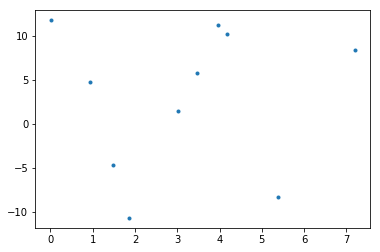

In [16]:
np.random.seed(42)

T = tf.float64

N = int(max_time / s_size + 1)

t_, x_, v_, a_ = sho_integrate(x0_tf, v0_tf, k_tf, N, s_size)
#interpx = CubicInterpolator(t_, x_, dtype=T)
#interpv = CubicInterpolator(t_, v_, dtype=T)
#x_in = interpx.evaluate(t_obs_tf)
#v_in = interpv.evaluate(t_obs_tf)
x_in = interp1d(t_obs_tf, t_, x_)
v_in = interp1d(t_obs_tf, t_, v_)


loglike  = -0.5 * tf.reduce_sum(tf.square((x_obs - x_in) / std_noise_x)) - np.log(std_noise_x)
loglike += -0.5 * tf.reduce_sum(tf.square((v_obs - v_in) / std_noise_v)) - np.log(std_noise_v)

plt.plot(t_obs_tf.eval(), x_obs, ".")

var = [k_tf, x0_tf, v0_tf]
grad = tf.gradients(-loglike, var)
cpp_loglikelihood = session.run(loglike)
%timeit session.run(loglike)
grads_cpp = session.run(grad)
%timeit session.run(grad)

## Now plot some stuff

In [17]:
print(cpp_loglikelihood, tensorflow_loglikelihood)
print(grads_cpp)
print(grads_tensorflow)

-206.4645684693808 -206.46460685936802
[-910.5099667101558, -23.75924578879698, 40.66163390418884]
[-910.5101992372192, -23.759207197255158, 40.661667360756546, IndexedSlicesValue(values=array([   0.        , -146.38756447, -137.79524745, -266.29821496,
       -212.02479001,  -50.88585973, -120.28136598, -104.04464266,
        -33.58164268, -105.84230816,  -23.90589498]), indices=array([0, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int32), dense_shape=array([10], dtype=int32))]


In [18]:
#generate values using python leapfrog from initial guesses to plot
plot_t_obs_values = np.linspace(0, max_time, 1000)
xleap_plot, vleap_plot, gradleap_plot, timeleap_plot = leapfrog(x0_guess,
                                            v0_guess,
                                            plot_t_obs_values,
                                            potential_and_grad_py,
                                            s_size,
                                            k=k_guess)

In [19]:
#generate values using python leapfrog from initial guesses to compare with tf model
xleap, vleap, gradleap, timeleap = leapfrog(x0_guess,
                                            v0_guess,
                                            t0_guess,
                                            potential_and_grad_py,
                                            s_size,
                                            k=k_guess)

In [20]:
v_in.eval()

array([  9.70481411, -13.95511851, -17.18766713, -11.42493295,
        16.28940216,  16.8006449 ,   7.37871095,   1.81656029,
       -16.83620387,  17.53650143])

In [21]:
vleap

array([  9.70481568, -13.95512287, -17.18767271, -11.42493655,
        16.28940687,  16.80065017,   7.37871308,   1.8165607 ,
       -16.83620695,  17.53650569])

/mnt/xfs1/flatiron-sw/pkg/devel/python3/3.6.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


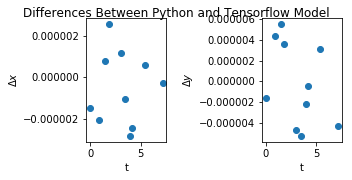

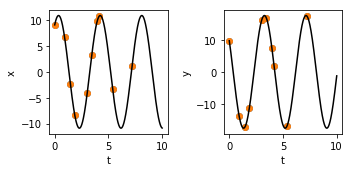

In [22]:

#now plot some stuff
fig, ax = plt.subplots(1,2, figsize=(5, 2.5))
ax[0].plot(t0_guess, x_in.eval() - xleap, 'o')
#print(session.run(x))
ax[0].set_xlabel('t')
ax[0].set_ylabel('$\Delta x$')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$\Delta y$')
ax[1].plot(t0_guess, v_in.eval() - vleap, 'o')
fig.suptitle('Differences Between Python and Tensorflow Model')
plt.tight_layout()

fig, ax = plt.subplots(1,2, figsize=(5, 2.5))
ax[0].plot(t0_guess, xleap, 'o', label='python')
ax[0].plot(t0_guess, x_in.eval(), 'o', label='tf')
ax[0].plot(t_compare, x_many, 'k-')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].plot(t0_guess, vleap, 'o')
ax[1].plot(t0_guess, v_in.eval(), 'o')
ax[1].plot(t_compare, v_many, 'o
plt.legend()
plt.tight_layout()

## Print the gradients to show Tensorflow, Autograd, and Finite Differences generate the same values

In [23]:
print('Python loglikelihood is: {0}'.format(python_loglikelihood))
print('Tensorflow loglikelihood is: {0}'.format(tensorflow_loglikelihood))

NameError: name 'python_loglikelihood' is not defined

In [ ]:
keys = ['k', 'x0', 'v0'] + ['tobs']*nobspoints
print('Gradients of Negative Log Likelihood')
print('  TensorFlow  Autograd  FiniteDifference ')
for tg, ag, fg, k in zip(grads_tensorflow[0:3], grads_autograd[0:3], grads_finite_difference[0:3], keys[0:3]):
    print('{0}  {1:0.3f}   {2:0.3f}   {3:0.3f}'.format(k, tg, ag, fg))

In [ ]:
print('Gradients of Negative Log Likelihood')
print('  TensorFlow  Autograd  FiniteDifference ')
for tg, ag, fg, k in zip(grads_tensorflow[3].values[::-1][:-1], grads_autograd[3:], grads_finite_difference[3:], keys[3:]):
    print('{0}   {1:0.3f}    {2:0.3f}    {3:0.3f}'.format(k, tg, ag, fg))

In [ ]:
%timeit grads_autograd = grad_ln_like(p0_guess, data, s_size)

In [ ]:
epsilon = 0.0001
%timeit grads_finite_difference = finite_difference_grads(k_guess, x0_guess, v0_guess, t0_guess, epsilon)

In [ ]:
%timeit session.run(ll)

In [ ]:
%timeit session.run(gradients)